# Experiment 8: Adversarial Debiasing (AIF360) - Retrain + Validate

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Step 0: Setup Environment
!pip install aif360 shap scikit-learn pandas matplotlib seaborn joblib openpyxl --quiet

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [19]:
# Step 1: Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric


In [20]:
# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


In [21]:
# Step 3: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])



In [22]:
# Step 4: Train Adversarial Debiasing Model

tf.reset_default_graph()
sess = tf.Session()

adversary = AdversarialDebiasing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    scope_name='adv_debiasing',
    debias=True,
    sess=sess
)

print("Training adversarial debiasing model...")
adversary.fit(aif_data)


Training adversarial debiasing model...
epoch 0; iter: 0; batch classifier loss: 9.007820; batch adversarial loss: -84.706650
epoch 1; iter: 0; batch classifier loss: 20.655209; batch adversarial loss: -12.159222
epoch 2; iter: 0; batch classifier loss: 19.993382; batch adversarial loss: -28.649624
epoch 3; iter: 0; batch classifier loss: 14.018869; batch adversarial loss: -49.366993
epoch 4; iter: 0; batch classifier loss: 18.738190; batch adversarial loss: -61.536255
epoch 5; iter: 0; batch classifier loss: 9.140605; batch adversarial loss: -92.661499
epoch 6; iter: 0; batch classifier loss: 10.333830; batch adversarial loss: -90.729790
epoch 7; iter: 0; batch classifier loss: 12.831044; batch adversarial loss: -94.665710
epoch 8; iter: 0; batch classifier loss: 7.887950; batch adversarial loss: -97.740326
epoch 9; iter: 0; batch classifier loss: 7.387584; batch adversarial loss: -112.545303
epoch 10; iter: 0; batch classifier loss: 6.853405; batch adversarial loss: -139.097672
epoch

In [23]:
# Step 5: Preprocess External Test Dataset
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()


In [24]:



# Step 6: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_test = StandardDataset(df_processed,
                               label_name='loan_status',
                               favorable_classes=[1],
                               protected_attribute_names=['zip_code'],
                               privileged_classes=[[1]])

    preds = model.predict(aif_test)
    y_true = aif_test.labels.ravel()
    y_pred = preds.labels.ravel()
    y_prob = preds.scores.ravel()

    print('\nPERFORMANCE METRICS')
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_prob))

    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    print('\nFAIRNESS METRICS')
    metric = ClassificationMetric(aif_test, preds,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    print("Statistical Parity Difference:", metric.statistical_parity_difference())
    print("Disparate Impact:", metric.disparate_impact())
    print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
    print("Average Odds Difference:", metric.average_odds_difference())
    print("Bias Amplification:", metric.between_group_generalized_entropy_index())
    print("Theil Index:", metric.theil_index())

    print('\nEXPLAINABILITY METRICS')
    # Use KernelExplainer since adversarial debiasing is not tree-based
    X_df = pd.DataFrame(aif_test.features, columns=aif_test.feature_names)
    background = X_df.values[:20] if X_df.shape[0] > 20 else X_df.values
    explainer = shap.KernelExplainer(lambda x: model.predict(
        StandardDataset(pd.DataFrame(x, columns=aif_test.feature_names)
                        .assign(loan_status=0),
                        label_name='loan_status',
                        favorable_classes=[1],
                        protected_attribute_names=['zip_code'],
                        privileged_classes=[[1]])).scores.ravel(),
        background)

    eval_n = min(50, X_df.shape[0])
    eval_data = X_df.values[:eval_n]
    shap_values = explainer.shap_values(eval_data, nsamples=100)

    if isinstance(shap_values, list):
        sv = shap_values[0]
    else:
        sv = shap_values

    shap.summary_plot(sv, pd.DataFrame(eval_data, columns=aif_test.feature_names), show=False)
    plt.title('SHAP Summary - Experiment 8 (Adversarial Debiasing)')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/shap_exp8_testdata.png', dpi=150)
    plt.show()

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    }



PERFORMANCE METRICS
Accuracy: 0.1887622475504899
Precision: 0.7272727272727273
Recall: 0.0019694731659281144
F1 Score: 0.003928308372207218
AUC-ROC: 0.5503177846677877

Classification Report:
              precision    recall  f1-score   support

         0.0       0.19      1.00      0.32       939
         1.0       0.73      0.00      0.00      4062

    accuracy                           0.19      5001
   macro avg       0.46      0.50      0.16      5001
weighted avg       0.63      0.19      0.06      5001


FAIRNESS METRICS
Statistical Parity Difference: 0.0
Disparate Impact: 1.0
Equal Opportunity Difference: nan
Average Odds Difference: nan
Bias Amplification: 277.3333333333334
Theil Index: 1.6653089584910115

EXPLAINABILITY METRICS


  0%|          | 0/50 [00:00<?, ?it/s]

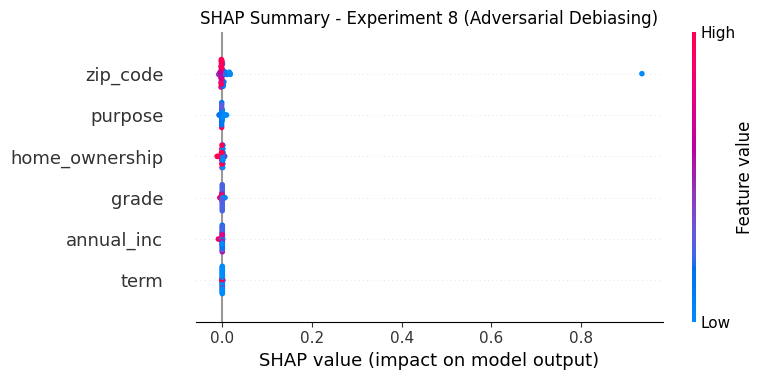

In [25]:

# Step 7: Run Validation
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'
TESTDATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'

test_df = pd.read_excel(TESTDATA_PATH)
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, adversary)



In [26]:
# Step 8: Save Results
results_df = pd.DataFrame([results])
output_path = f'{RESULTS_DIR}/experiment8_validation_results_testdata.csv'
results_df.to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment8_validation_results_testdata.csv
